In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import backend as K
from keras import callbacks 

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import joblib


**Define input data and plot them**

In [2]:
# Define lookback and prediction time_step
lookback = 10

#number of outputs
time_step = 1
n_outputs = 2

patience=300
drop=0.1

test_size = 10
future_size = 28

#number of all features (inputs +outputs)
n_features = 3

n_epochs=3000

In [3]:
#number od days
n = 59

final_sequence = []
increment = 10

final_sequence=[increment+2*i for i in range(n)]
final_sequence[0:5]

#convert into df
data_origin=pd.DataFrame(final_sequence, columns=['item'])
data_origin.head(16)

,item
0,10
1,12
2,14
3,16
4,18
5,20
6,22
7,24
8,26
9,28


In [4]:
def zero_value(data):
    data.loc[data['weekend'] == 1, 'item'] = 0
    return data

**Add 'date' and 'weekend' column**

In [5]:
data_origin['date']=pd.date_range('2023-01-01', periods=len(data_origin),)
data_origin['weekend']=data_origin['date'].dt.weekday
data_origin['weekend']=data_origin['weekend'].apply(lambda x: 1 if x in [5,6] else 0)

#zero the weekends values
data_origin = zero_value(data_origin)

**Add column 'profit'**

In [6]:
# Add another column 
data_origin['profit']=data_origin['item']*3
data_origin.head(10)

,item,date,weekend,profit
0,0,2023-01-01,1,0
1,12,2023-01-02,0,36
2,14,2023-01-03,0,42
3,16,2023-01-04,0,48
4,18,2023-01-05,0,54
5,20,2023-01-06,0,60
6,0,2023-01-07,1,0
7,0,2023-01-08,1,0
8,26,2023-01-09,0,78
9,28,2023-01-10,0,84


In [7]:
# Reorder columns to make 'date' the first column
data_origin = data_origin[['date', 'item','profit', 'weekend']]


#set the index
data_origin.set_index('date', inplace=True)

data_origin.head(5)

,item,profit,weekend
date,,,
2023-01-01,0,0,1
2023-01-02,12,36,0
2023-01-03,14,42,0
2023-01-04,16,48,0
2023-01-05,18,54,0


In [8]:
data_origin.tail(8)

,item,profit,weekend
date,,,
2023-02-21,112,336,0
2023-02-22,114,342,0
2023-02-23,116,348,0
2023-02-24,118,354,0
2023-02-25,0,0,1
2023-02-26,0,0,1
2023-02-27,124,372,0
2023-02-28,126,378,0


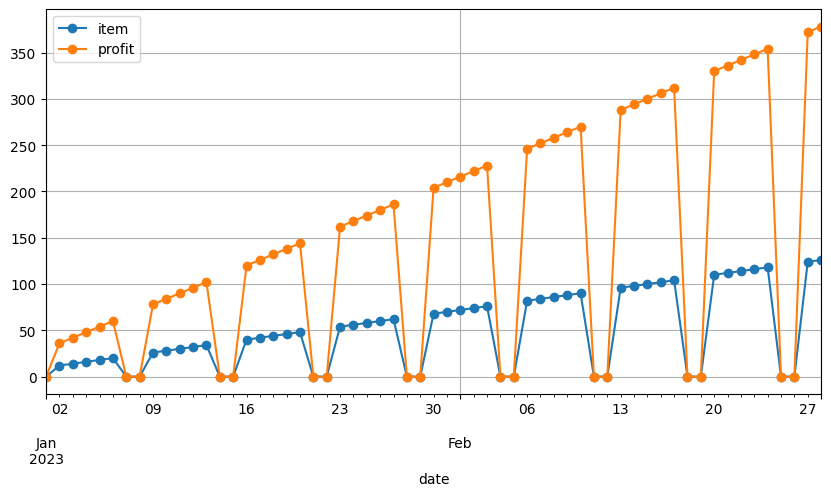

In [9]:
data_origin[['item', 'profit']].plot(figsize=(10,5), marker='o')
plt.grid()
plt.show()

## PART I - Predict on the test set

**Scale and parce the data**

In [10]:
#scale data
scaler = MinMaxScaler(feature_range = (0,1))
data = scaler.fit_transform(data_origin)

In [11]:
# Function to create input sequences and corresponding output for training
def create_sequences(data, lookback, time_step):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :])
        y.append(data[i+lookback:i+lookback+time_step, 0:n_outputs]) #I want to predict first 2 values that is why (0,2)
    return np.array(X), np.array(y)

# Create input sequences and corresponding output
X, y = create_sequences(data, lookback, time_step)

In [12]:
X.shape

(49, 10, 3)

In [13]:
#Split the data into training and testing sets
train_size = int(len(X)-test_size)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

**Build the NN and compute**

In [14]:
""" from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define the input shape
input_shape = (1, input_feature_size)  # Assuming input_feature_size is the size of your input features

# Input layer
inputs = Input(shape=input_shape, name='input_layer')

# LSTM layer
lstm_out = LSTM(units=hidden_units, activation='tanh', return_sequences=False)(inputs)

# Output layers
output1 = Dense(units=output1_units, activation='linear', name='output1')(lstm_out)
output2 = Dense(units=output2_units, activation='linear', name='output2')(lstm_out)

# Create the model
model = Model(inputs=inputs, outputs=[output1, output2])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss function and optimizer as needed """


" from tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, LSTM, Dense\n\n# Define the input shape\ninput_shape = (1, input_feature_size)  # Assuming input_feature_size is the size of your input features\n\n# Input layer\ninputs = Input(shape=input_shape, name='input_layer')\n\n# LSTM layer\nlstm_out = LSTM(units=hidden_units, activation='tanh', return_sequences=False)(inputs)\n\n# Output layers\noutput1 = Dense(units=output1_units, activation='linear', name='output1')(lstm_out)\noutput2 = Dense(units=output2_units, activation='linear', name='output2')(lstm_out)\n\n# Create the model\nmodel = Model(inputs=inputs, outputs=[output1, output2])\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss function and optimizer as needed "

**Set up the model**

In [15]:
#Build the LSTM model

'''
If you encounter this problem:
"The error AttributeError: module 'keras.backend' has no attribute 'floatx'"
Restart VSC!!!
'''

#clear previous TensorFlow session
K.clear_session()

model = Sequential()
model.add(LSTM(40, input_shape=(lookback, n_features), return_sequences=True)) #for multioutput better to set: return_sequences=True
model.add(Dropout(drop))
model.add(Dense(n_outputs))

model.compile(optimizer='adam', loss='mse')

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 40)            7040      
                                                                 
 dropout (Dropout)           (None, 10, 40)            0         
                                                                 
 dense (Dense)               (None, 10, 2)             82        
                                                                 
Total params: 7122 (27.82 KB)
Trainable params: 7122 (27.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fit the model and run the computation**

In [16]:
#set the early stopping
early_stopping=callbacks.EarlyStopping(patience=patience)

#Train the model
history=model.fit(X_train, y_train, 
                  epochs=n_epochs, 
                  batch_size=10, 
                  validation_data=(X_test, y_test), 
                  callbacks=[early_stopping],
                  verbose=0)

#Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


1/1 [==============================] - 0s 355ms/step - loss: 0.0407
Test Loss: 0.04071715474128723


In [17]:
#define ploting function for loss function

def plot_training(history_dict, y_axis=[0, 1000]):

    plt.plot(history_dict.history['loss'], label='Loss-Training',  c="blue")
    plt.plot(history_dict.history['val_loss'], label='Loss-Test', c="red")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(y_axis) #limit of the Y-axis

    plt.legend()
    plt.grid(True)

    plt.show()

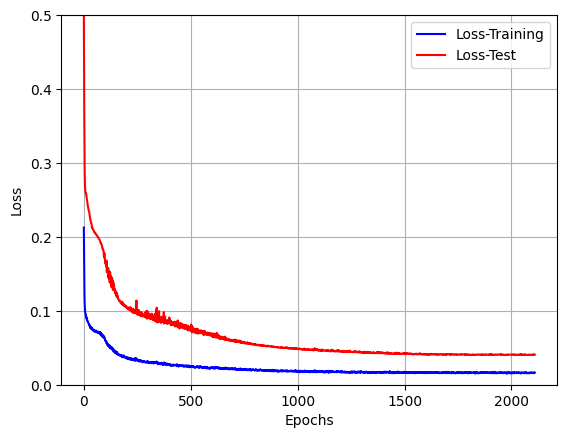

In [18]:
#plot without dropout
plot_training(history,y_axis=[0, 0.5])

**Predict on the test data**

In [19]:
#Predict the next time steps
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 355ms/step


**Back-transformation-Prediction**

In [20]:
y_pred.shape

(10, 10, 2)

In [21]:
#get the latest array = predictions, slice it
y_pred_reshaped = y_pred[:, -1, :]
y_pred_reshaped.shape

(10, 2)

In [22]:
y_pred_reshaped

array([[0.03635797, 0.03657848],
       [0.85943305, 0.8571224 ],
       [0.88235915, 0.8818273 ],
       [0.8956895 , 0.8950985 ],
       [0.91359365, 0.91130465],
       [0.9225514 , 0.9198919 ],
       [0.02895071, 0.02978791],
       [0.05921727, 0.05983681],
       [0.9625634 , 0.95900494],
       [0.9953629 , 0.9938618 ]], dtype=float32)

In [23]:
def back_transform(df, n_features=n_features, n_outputs=n_outputs, array=True):

    #duplicate the array - for transformations reasons
    transformed_array = np.repeat(df, n_features, axis=-1)

    #slice the array
    transformed_array=transformed_array[:,0:n_features]

    #tranform back
    transformed_array=scaler.inverse_transform(transformed_array)[:,0:n_outputs]
    
    #create a dataframe
    if array !=True:
        transformed_array=pd.DataFrame(transformed_array, columns=['pred1', 'pred2'])

    return transformed_array

In [24]:
y_pred_trans=back_transform(y_pred_reshaped, n_features=n_features, n_outputs=n_outputs, array=True)

**Back-transformation-Test**

In [25]:
y_test.shape

(10, 1, 2)

In [26]:
y_test_reshaped = y_test.reshape((lookback, n_outputs))
y_test_reshaped.shape

(10, 2)

In [27]:
y_test_trans=back_transform(y_test_reshaped, n_features=n_features, n_outputs=n_outputs, array=True)

**Plot results**

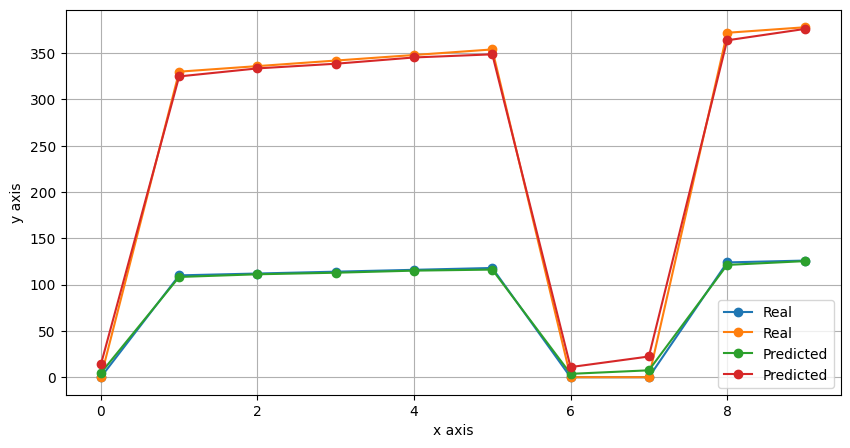

In [28]:
#Plot results for test part

plt.figure(figsize=(10,5))

plt.plot(y_test_trans, label = 'Real', marker='o')
plt.plot(y_pred_trans, label = 'Predicted', marker='o')

plt.grid()
plt.ylabel('y axis')
plt.xlabel('x axis')

plt.legend()
plt.show()

**Evaluate test data - RMSE**

In [29]:
#calculate root mean squared error
test_score1 = np.sqrt(mse(y_test_trans[0], y_pred_trans[0]))

#calculate root mean squared error
test_score2 = np.sqrt(mse(y_test_trans[1], y_pred_trans[1]))

#print results
print(f'RMSE-output1: {round(test_score1,2)} \nRMSE-output2: {round(test_score2,2)}')


RMSE-output1: 10.24 
RMSE-output2: 3.83


In [30]:
#Fit the model on the whole dataset (including test set)
history=model.fit(X,y, epochs=n_epochs, batch_size=10, verbose=0)
final_loss = history.history['loss'][-1]
final_loss

0.0202782079577446

In [31]:
#Save the fitted model
joblib.dump(model, 'lstm-model-multivariate-multioutput.pkl')

['lstm-model-multivariate-multioutput.pkl']

## PART II - Predict beyond the test set

**Create a matrix**

In [32]:
#get the last date item
first_date=data_origin.index[-1] + pd.Timedelta(days=1)
first_date

Timestamp('2023-03-01 00:00:00')

In [33]:
#get the future prediction
df_future=pd.DataFrame({'date': pd.date_range(first_date,periods=future_size)})

#add nan we will predict them
df_future['item']=np.nan
df_future['profit']=np.nan

#add weekend column
df_future['weekend']=df_future['date'].dt.weekday
df_future['weekend']=df_future['weekend'].apply(lambda x: 1 if x in [5,6] else 0)
df_future=df_future.set_index('date')

df_future

,item,profit,weekend
date,,,
2023-03-01,NaN,NaN,0
2023-03-02,NaN,NaN,0
2023-03-03,NaN,NaN,0
2023-03-04,NaN,NaN,1
2023-03-05,NaN,NaN,1
2023-03-06,NaN,NaN,0
2023-03-07,NaN,NaN,0
2023-03-08,NaN,NaN,0
2023-03-09,NaN,NaN,0


In [34]:
#take data from the test set
df_test=data_origin[-test_size:].copy()
df_test

,item,profit,weekend
date,,,
2023-02-19,0,0,1
2023-02-20,110,330,0
2023-02-21,112,336,0
2023-02-22,114,342,0
2023-02-23,116,348,0
2023-02-24,118,354,0
2023-02-25,0,0,1
2023-02-26,0,0,1
2023-02-27,124,372,0


In [35]:
#merge the df
df_prediction_final=pd.concat([df_test, df_future], axis=0)
df_prediction_final

,item,profit,weekend
date,,,
2023-02-19,0.0,0.0,1
2023-02-20,110.0,330.0,0
2023-02-21,112.0,336.0,0
2023-02-22,114.0,342.0,0
2023-02-23,116.0,348.0,0
2023-02-24,118.0,354.0,0
2023-02-25,0.0,0.0,1
2023-02-26,0.0,0.0,1
2023-02-27,124.0,372.0,0


In [36]:
#scale data and transform them into an array
scaler = MinMaxScaler(feature_range = (0,1))
df_prediction_final_scaled = scaler.fit_transform(df_prediction_final)

In [37]:
#array BEFORE the prediction
df_prediction_final_scaled 

array([[0.        , 0.        , 1.        ],
       [0.87301587, 0.87301587, 0.        ],
       [0.88888889, 0.88888889, 0.        ],
       [0.9047619 , 0.9047619 , 0.        ],
       [0.92063492, 0.92063492, 0.        ],
       [0.93650794, 0.93650794, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.98412698, 0.98412698, 0.        ],
       [1.        , 1.        , 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 1.        ],
       [       nan,        nan, 1.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 0.        ],
       [       nan,        nan, 1.        ],
       [       nan,        nan, 1.        ],
       [  

In [38]:
df_prediction_final_scaled.shape

(38, 3)

In [39]:
#define the function for the prediction
def predict_multivariate(array, lookback):
    #results=[]
    for i in range(len(array)-lookback):
        
        batch=[]
        batch.append(array[i:i+lookback , :]) #number of columns
        batch=np.array(batch)
      
        #predict one value
        prediction=model.predict(batch, verbose=0)[0]
        
        #add to the prediction list
        #results.append(prediction[-1]) #takes the last value as we set sequences

        #replace nan in the array for next iterration
        array[i+lookback, 0:n_outputs] = prediction[-1]
        
    return array[-future_size: , 0:n_outputs]

In [40]:
#call the function and predict
results=predict_multivariate(df_prediction_final_scaled, lookback)
#results

In [41]:
#array AFTER the prediction
df_prediction_final_scaled

array([[ 0.        ,  0.        ,  1.        ],
       [ 0.87301587,  0.87301587,  0.        ],
       [ 0.88888889,  0.88888889,  0.        ],
       [ 0.9047619 ,  0.9047619 ,  0.        ],
       [ 0.92063492,  0.92063492,  0.        ],
       [ 0.93650794,  0.93650794,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.98412698,  0.98412698,  0.        ],
       [ 1.        ,  1.        ,  0.        ],
       [ 1.01800799,  1.01800823,  0.        ],
       [ 1.03780818,  1.03779435,  0.        ],
       [ 1.04360318,  1.04359722,  0.        ],
       [-0.01497093, -0.01495084,  1.        ],
       [-0.009011  , -0.00901461,  1.        ],
       [ 1.09451318,  1.09452021,  0.        ],
       [ 1.1124022 ,  1.11241305,  0.        ],
       [ 1.12963367,  1.12963688,  0.        ],
       [ 1.14364064,  1.14362741,  0.        ],
       [ 1.13776064,  1.13775563,  0.        ],
       [-0.02929771, -0.02926895,  1.   

**Transform back**

In [42]:
#call the function
pokus=back_transform(results, n_features=n_features, n_outputs=n_outputs, array=False)

**Add columns**

In [43]:
pokus['date']=pd.date_range(first_date, periods=future_size)

pokus=pokus.set_index('date')

pokus.head(5)


,pred1,pred2
date,,
2023-03-01,128.269007,384.807022
2023-03-02,130.763831,392.291492
2023-03-03,131.494001,394.482003
2023-03-04,-1.886337,-5.659011
2023-03-05,-1.135386,-3.406158


In [44]:
df_prediction=pd.concat([data_origin[['item','profit']], pokus], axis=1)
#df_prediction.rename(columns={'item': 'true'}, inplace=True)
df_prediction.tail(16)

,item,profit,pred1,pred2
date,,,,
2023-03-13,NaN,NaN,149.663002,448.989005
2023-03-14,NaN,NaN,153.039295,459.117886
2023-03-15,NaN,NaN,155.905257,467.715772
2023-03-16,NaN,NaN,156.590306,469.770919
2023-03-17,NaN,NaN,153.784186,461.352557
2023-03-18,NaN,NaN,-5.310223,-15.930669
2023-03-19,NaN,NaN,-2.801588,-8.404765
2023-03-20,NaN,NaN,160.093673,480.281018
2023-03-21,NaN,NaN,164.912613,494.737839


**Plot**

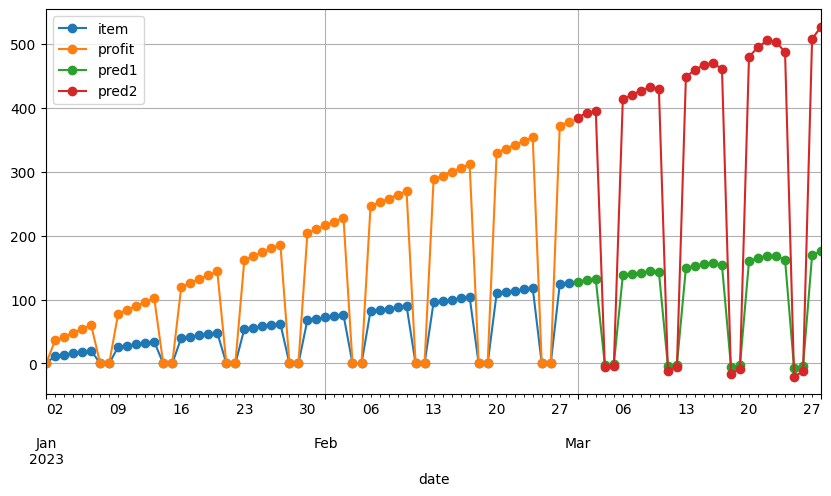

In [45]:
#Plot a chart
df_prediction[['item', 'profit', 'pred1', 'pred2']].plot(figsize=(10, 5), marker='o')
plt.grid(True)
plt.show()